In [1]:
# Cell 1: Imports for CLIP Training
import os
import sys
import random
import glob
import datetime
import time
import subprocess
import shlex
import warnings
from pathlib import Path
# os.chdir("/home1/jijh/diffusion_project/ADiffusion") # If running script directly
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
# from torch_geometric.loader import DataLoader as PyGDataLoader # Defined in script
from torch_geometric.nn import GPSConv, GATConv # For GraphConditioner

# Filter warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# %matplotlib inline # If you plan to add inline plotting for something

In [2]:
# Cell 2: REFACTORED Configuration Class for CLIP Training

class TrainingConfigCLIP:
    # --- Hardware & Precision ---
    GPU_IDS = [1, 2]
    NUM_GPUS = len(GPU_IDS) if torch.cuda.is_available() and GPU_IDS else 0
    PRIMARY_DEVICE_NAME = f"cuda:{GPU_IDS[0]}" if NUM_GPUS > 0 else "cpu"
    MIXED_PRECISION_TYPE = "bf16" # "bf16", "fp16", or "no"
    DDP_MASTER_PORT = 29503

    # --- Data Paths (MODIFIED) ---
    # [MODIFIED] This MUST point to your new directory with preprocessed graphs (containing data.y).
    GRAPH_DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient"

    # [REMOVED] Obsolete paths. Data is self-contained in the new graph files.
    # GIGAPATH_FEATURE_DIR = "..."
    # ORIGINAL_LATENT_DIR_BASE_FOR_PATH_RECONSTRUCTION = "..."

    # --- Model Architecture ---
    # The conditioner's input dimension must match the node features in your graphs.
    CONDITIONER_INPUT_DIM = 50 # This was your PCA_N_COMPS

    # The MLP's input dimension must match the GigaPath features stored in data.y.
    # It is defined as the first element in IMAGE_ENCODER_MLP_LAYERS.
    GIGAPATH_EMBED_DIM_FROM_PREPROCESSING = 1536 # Use the dim from your GigaPath notebook (e.g. 1024)
    
    # Common embedding space dimension for both modalities.
    CLIP_EMBED_DIM = 768
    
    # Graph Conditioner (context encoder)
    CONDITIONER_HIDDEN_DIM = 256
    CONDITIONER_N_LAYERS = 4
    CONDITIONER_N_HEADS = 4
    CONDITIONER_ATTN_DROPOUT = 0.1

    # Image Encoder (projects GigaPath features into the common space)
    IMAGE_ENCODER_MLP_LAYERS = [GIGAPATH_EMBED_DIM_FROM_PREPROCESSING, 1024, CLIP_EMBED_DIM]

    # Logit scale for contrastive loss (learnable)
    CLIP_LOGIT_SCALE_INIT = np.log(1 / 0.07) # Standard CLIP initialization

    # --- Training Hyperparameters ---
    CLIP_BATCH_SIZE_PER_GPU = 64
    CLIP_NUM_EPOCHS = 50
    CLIP_LEARNING_RATE = 1e-4
    CLIP_WEIGHT_DECAY = 0.01
    ACCUMULATION_STEPS = 1
    NUM_WORKERS = 16

    # --- Debugging & Reproducibility ---
    # Set > 0 to train on a small random subset of graphs for fast debugging.
    DEBUG_NUM_GRAPHS = 2  # <-- Set to 0 to use all graphs
    SEED = 42

    # --- Logging & Saving ---
    # [MODIFIED] Using a different checkpoint/log dir to avoid mixing with old runs.
    CHECKPOINT_DIR = f"/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2_sample{DEBUG_NUM_GRAPHS}_accustep{ACCUMULATION_STEPS}_lr{CLIP_LEARNING_RATE}_wd{CLIP_WEIGHT_DECAY}_batchsize{CLIP_BATCH_SIZE_PER_GPU}_epochs{CLIP_NUM_EPOCHS}_seed{SEED}"
    LOG_DIR = "/cwStorage/nodecw_group/jijh/training_log/clip_preprocessed_v2_sample{DEBUG_NUM_GRAPHS}_accustep{ACCUMULATION_STEPS}_lr{CLIP_LEARNING_RATE}_wd{CLIP_WEIGHT_DECAY}_batchsize{CLIP_BATCH_SIZE_PER_GPU}_epochs{CLIP_NUM_EPOCHS}_seed{SEED}"
    CHECKPOINT_FILENAME_PREFIX = "clip_graph_gigapath_preprocessed"
    # [MODIFIED] Ensure this points to the new, simplified training script.
    TRAIN_SCRIPT_PATH = "/home1/jijh/diffusion_project/ADiffusion/src/pipeline/train_clip_graph_gigapath_ddp_graphinput.py"
    SAVE_INTERVAL_EPOCHS = 10
    LOG_INTERVAL_STEPS = 50

    @classmethod
    def get_script_args(cls):
        """Generates command-line arguments for the simplified training script."""
        args = [
            # --- Key Paths ---
            f"--graph_data_dir={cls.GRAPH_DATA_DIR}",
            f"--checkpoint_dir={cls.CHECKPOINT_DIR}",
            f"--log_dir={cls.LOG_DIR}",

            # --- Training Hyperparameters ---
            f"--epochs={cls.CLIP_NUM_EPOCHS}",
            f"--batch_size_per_gpu={cls.CLIP_BATCH_SIZE_PER_GPU}",
            f"--lr={cls.CLIP_LEARNING_RATE}",
            f"--weight_decay={cls.CLIP_WEIGHT_DECAY}",
            f"--accumulation_steps={cls.ACCUMULATION_STEPS}",
            f"--mixed_precision={cls.MIXED_PRECISION_TYPE}",
            f"--num_workers={cls.NUM_WORKERS}",

            # --- Model Architecture ---
            f"--conditioner_input_dim={cls.CONDITIONER_INPUT_DIM}",
            f"--conditioner_hidden_dim={cls.CONDITIONER_HIDDEN_DIM}",
            f"--conditioner_output_dim={cls.CLIP_EMBED_DIM}", # Conditioner outputs to CLIP embedding dim
            f"--conditioner_n_layers={cls.CONDITIONER_N_LAYERS}",
            f"--conditioner_n_heads={cls.CONDITIONER_N_HEADS}",
            f"--conditioner_attn_dropout={cls.CONDITIONER_ATTN_DROPOUT}",
            f"--clip_embed_dim={cls.CLIP_EMBED_DIM}",
            f"--image_encoder_mlp_layers={','.join(map(str, cls.IMAGE_ENCODER_MLP_LAYERS))}",
            f"--clip_logit_scale_init={cls.CLIP_LOGIT_SCALE_INIT}",

            # --- Logging & Saving ---
            f"--save_interval={cls.SAVE_INTERVAL_EPOCHS}",
            f"--log_interval={cls.LOG_INTERVAL_STEPS}",
            f"--checkpoint_filename_prefix={cls.CHECKPOINT_FILENAME_PREFIX}",
            
            # --- Debugging & Reproducibility ---
            f"--seed={cls.SEED}",
        ]
        
        # Only add the debug flag if it's active.
        if cls.DEBUG_NUM_GRAPHS > 0:
            args.append(f"--debug_num_graphs={cls.DEBUG_NUM_GRAPHS}")

        return args



In [3]:
# --- Instantiate config and create directories ---
config_clip = TrainingConfigCLIP()
os.makedirs(config_clip.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(config_clip.LOG_DIR, exist_ok=True)



In [4]:
# Cell 5: Launch DDP Training Script for CLIP
print("\n--- Preparing to Launch DDP Training Script for CLIP ---")
config_clip = TrainingConfigCLIP() # Reload config

if not os.path.exists(config_clip.TRAIN_SCRIPT_PATH):
    print(f"Error: CLIP Training script '{config_clip.TRAIN_SCRIPT_PATH}' not found.")
    print("Please create this script (train_clip_graph_gigapath_ddp.py).")
else:
    if config_clip.NUM_GPUS == 0 or not config_clip.GPU_IDS:
        print("Error: No GPUs specified in config_clip.GPU_IDS or CUDA not available.")
    else:
        python_executable = sys.executable
        print(f"Using Python executable: {python_executable}")
        print(f"Attempting to use {config_clip.NUM_GPUS} GPUs with IDs: {config_clip.GPU_IDS}")

        modified_env = os.environ.copy()
        cuda_visible_devices = ",".join(map(str, config_clip.GPU_IDS))
        modified_env["CUDA_VISIBLE_DEVICES"] = cuda_visible_devices
        print(f"Setting CUDA_VISIBLE_DEVICES={cuda_visible_devices} for the subprocess.")

        cmd = [
            python_executable,
            "-m", "torch.distributed.run",
            f"--nproc_per_node={config_clip.NUM_GPUS}",
            f"--master_port={config_clip.DDP_MASTER_PORT}",
            config_clip.TRAIN_SCRIPT_PATH,
        ]
        cmd.extend(config_clip.get_script_args())

        print("\nLaunching command for CLIP training:")
        print(shlex.join(cmd))
        print("-" * 30 + "\nScript Output:\n" + "-" * 30)

        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                                   text=True, bufsize=1, encoding='utf-8', errors='replace',
                                   env=modified_env)
        while True:
            output = process.stdout.readline()
            if output == '' and process.poll() is not None:
                break
            if output:
                try:
                    print(output.strip())
                except Exception as e_print:
                    print(f"[Encoding error in output: {e_print}]")
        rc = process.poll()
        print("-" * 30 + "\n--- CLIP Script Finished ---")
        if rc == 0:
            print("CLIP Training script finished successfully.")
        else:
            print(f"CLIP Training script exited with error code {rc}.")


--- Preparing to Launch DDP Training Script for CLIP ---
Using Python executable: /public/home/jijh/micromamba/envs/gpu_env/bin/python
Attempting to use 2 GPUs with IDs: [1, 2]
Setting CUDA_VISIBLE_DEVICES=1,2 for the subprocess.

Launching command for CLIP training:
/public/home/jijh/micromamba/envs/gpu_env/bin/python -m torch.distributed.run --nproc_per_node=2 --master_port=29503 /home1/jijh/diffusion_project/ADiffusion/src/pipeline/train_clip_graph_gigapath_ddp_graphinput.py --graph_data_dir=/cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient --checkpoint_dir=/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2_sample2_accustep1_lr0.0001_wd0.01_batchsize64_epochs50_seed42 '--log_dir=/cwStorage/nodecw_group/jijh/training_log/clip_preprocessed_v2_sample{DEBUG_NUM_GRAPHS}_accustep{ACCUMULATION_STEPS}_lr{CLIP_LEARNING_RATE}_wd{CLIP_WEIGHT_DECAY}_batchsize{CLIP_BATCH_SIZE_PER_GPU}_epochs{CLIP_NUM_EPOCHS}_seed{SEED}' --epochs=50 --batch_size_per_gpu=64 --lr=0.0

# Model Validation

['MEND129MEND73', 'NCBI340', 'NCBI362', 'NCBI371', 'NCBI374', 'NCBI375', 'NCBI639', 'NCBI663', 'NCBI670', 'NCBI808', 'SPA15', 'SPA6', 'TENX18', 'TENX19', 'TENX56']

In [5]:
# --- 核心库导入 ---
import os
import sys
import glob
import re
from pathlib import Path
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
import umap

# --- PyTorch Geometric 导入 ---
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GPSConv, GATConv

In [9]:
# Add the project path to sys.path if not already there
project_path = "/home1/jijh/diffusion_project/ADiffusion"
if project_path not in sys.path:
	sys.path.append(project_path)

# Now import using absolute import
from src.visualization.clip_eval import CLIPModelEvaluator

 CLIP Model Evaluator Initialized
  - Model Path: /cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2_sample2_accustep1_lr0.0001_wd0.01_batchsize64_epochs50_seed42/clip_graph_gigapath_preprocessed_ep50_step350_bs64x2_lr0.0001.pt
  - Sample IDs to Evaluate: ['NCBI340', 'NCBI371']
  - Device: cuda:0
  - Graph Data Directory: /cwStorage/nodecw_group/jijh/hest_graph_data_with_gigapath_y_resilient

--- [Step 1/4] Loading Model ---
  - Building model architecture...
  - Loading checkpoint 'clip_graph_gigapath_preprocessed_ep50_step350_bs64x2_lr0.0001.pt' to CPU first...
  - Loading state dictionary into model on target device...
  - ✅ Model loaded successfully and set to evaluation mode.

--- [Step 2/4] Loading Evaluation Data ---
  - Scanning 172 graph files to find 2 requested samples...


  - Scanning graphs:   0%|          | 0/172 [00:00<?, ?file/s]

    - Found and loaded: NCBI340 (276 nodes)
    - Found and loaded: NCBI371 (620 nodes)
  - ✅ Successfully loaded 2 graphs.

--- [Step 3/4] Running Inference ---
  - Processing a single batch with 2 graphs and 896 total nodes.
  - Generating GNN embeddings (from graph structure)...
  - Generating Image embeddings (from GigaPath features)...
  - Normalizing embeddings...
  - ✅ Inference complete.

--- [Step 4/4] Calculating Metrics & Visualizing ---
  - Calculating similarity matrix...

  --- Evaluation Metrics ---
    - Top-1 Retrieval Accuracy: 84.82% (760/896 nodes correctly paired)
    - Avg. Correct Pair Similarity (diagonal): 0.7090
    - Avg. Incorrect Pair Similarity (off-diagonal): -0.0003
    - Similarity Gap (the larger, the better): 0.7093
  --------------------------

  - Generating Visualization 1: Similarity Matrix Heatmap...


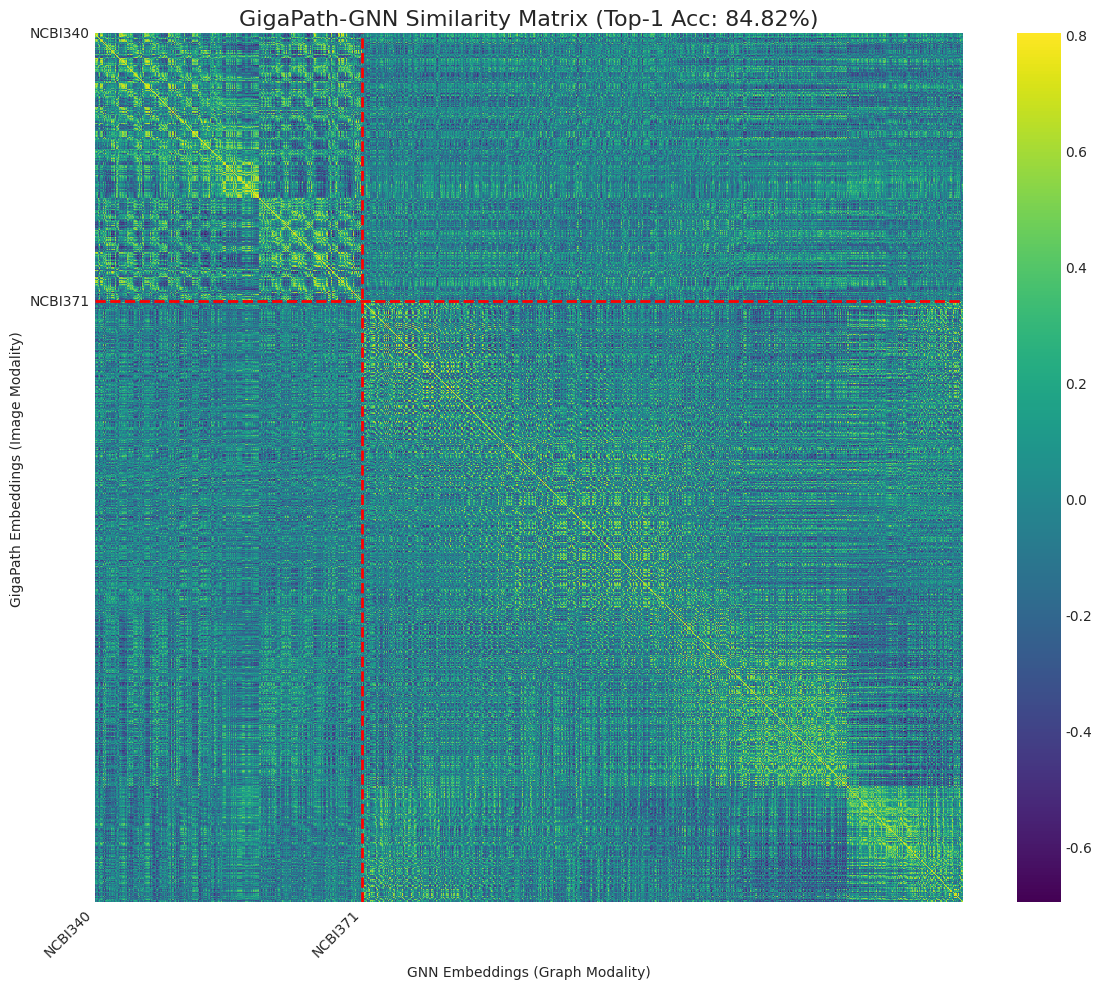

  - Generating Visualization 2: Similarity Distribution KDE Plot...


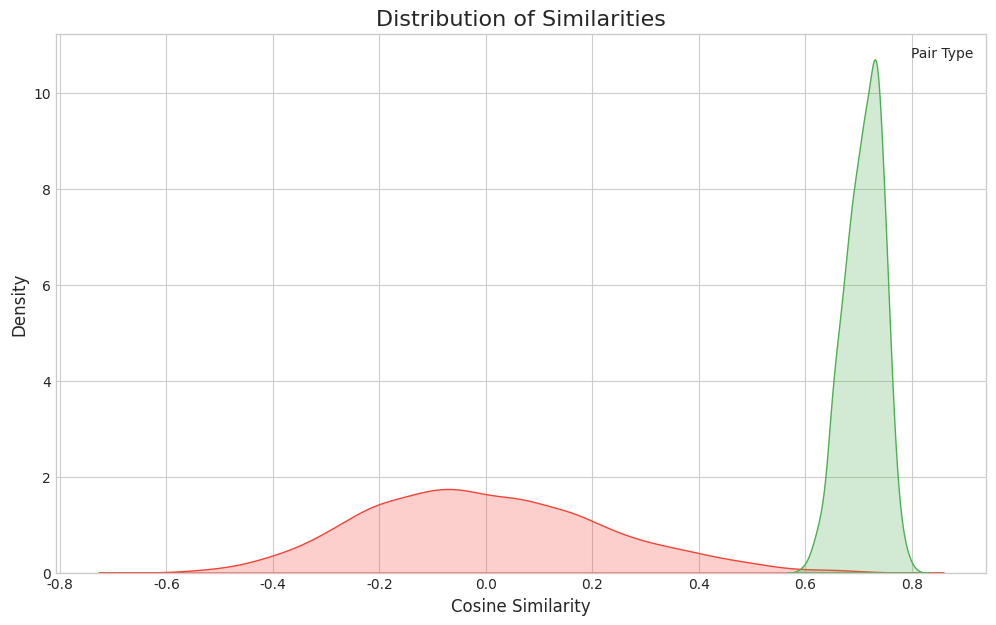

  - Generating Visualization 3: UMAP Embedding Space...
    - Running UMAP on all embeddings... (This may take a moment)


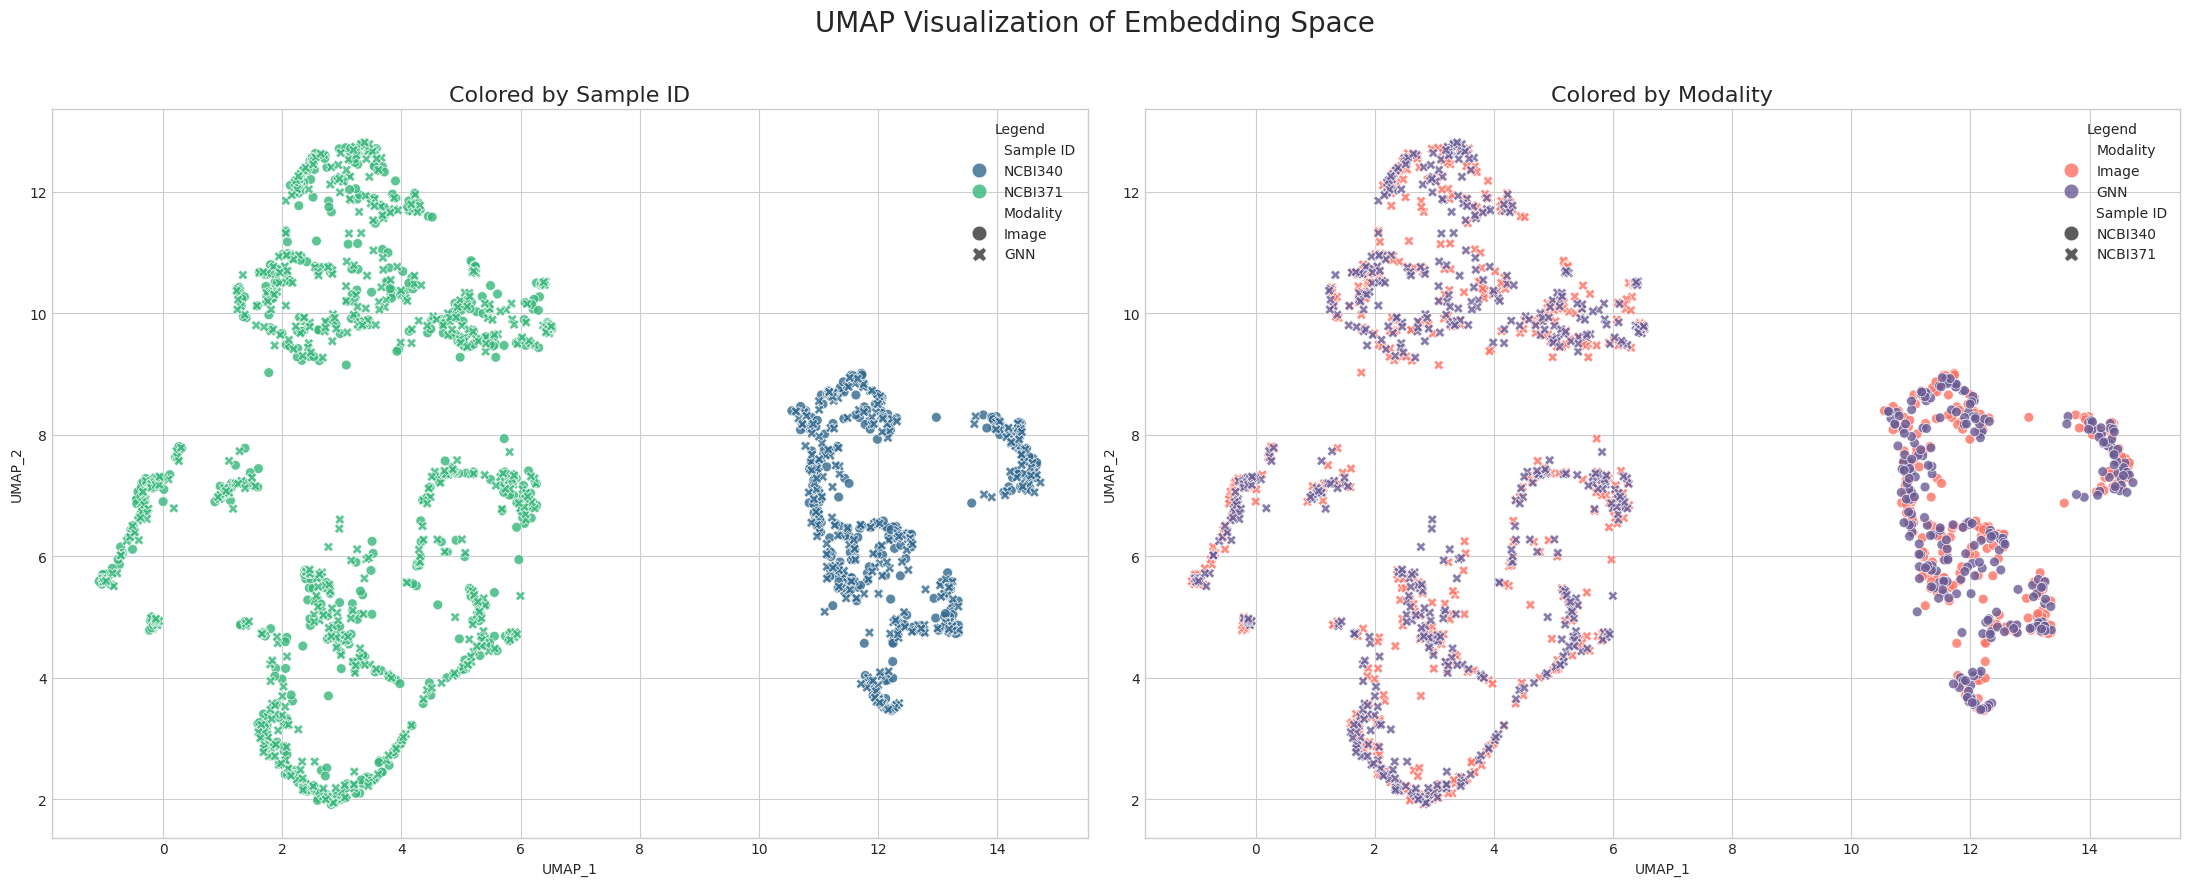


 Evaluation Complete! 🎉


In [10]:
MODEL_CHECKPOINT_PATH = "/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2_sample2_accustep1_lr0.0001_wd0.01_batchsize64_epochs50_seed42/clip_graph_gigapath_preprocessed_ep50_step350_bs64x2_lr0.0001.pt"

# ==============================================================================
# 3. 运行评估 (用户修改区域)
# ==============================================================================

# --- 在这里输入您的模型路径和想测试的样本ID ---

# 示例1：评估一个特定的checkpoint
# MODEL_CHECKPOINT_PATH = "/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2_sample16_accustep1_lr0.0001_wd0.01_batchsize64_epochs50_seed42/clip_graph_gigapath_preprocessed_ep49_step5_loss0.02.pt"



# 您想要检验的样本ID列表
SAMPLE_IDS_TO_EVALUATE = ['NCBI340', 'NCBI371'] # 也可以是 ['NCBI340'] 或更多样本

# --------------------------------------------------

# --- 实例化并运行评估器 ---
if __name__ == '__main__' and '__file__' not in globals(): # 确保在notebook中运行
    evaluator = CLIPModelEvaluator(
        model_path=MODEL_CHECKPOINT_PATH,
        sample_ids=SAMPLE_IDS_TO_EVALUATE
    )
    evaluator.run()

# Diffusion Model Training

In [2]:
# Cell 1: Imports and Configuration
import os
import sys
import random
import glob
import datetime
import time
import subprocess
import shlex
import re
import warnings
from pathlib import Path
import io

import numpy as np
import PIL.Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GPSConv, GATConv

from diffusers import AutoencoderTiny, UNet2DConditionModel, DDPMScheduler

warnings.filterwarnings('ignore')

# --- Configuration Class for Diffusion Training V3 ---
class TrainingConfigDiffusion:
    # --- Hardware & Precision ---
    GPU_IDS = [1, 2]
    NUM_GPUS = len(GPU_IDS) if torch.cuda.is_available() else 0
    DDP_MASTER_PORT = 29505
    MIXED_PRECISION_TYPE = "bf16"

    # --- Pre-trained models and training mode ---
    PRETRAINED_CONDITIONER_PATH = "/cwStorage/nodecw_group/jijh/model_path/clip_preprocessed_v2_sample2_accustep1_lr0.0001_wd0.01_batchsize64_epochs50_seed42/clip_graph_gigapath_preprocessed_ep50_step350_bs64x2_lr0.0001.pt"
    FREEZE_CONDITIONER = True # <--- 这个布尔值控制是否冻结
    PRETRAINED_UNET_PATH = "/cwStorage/nodecw_group/jijh/model_path/unet_ddp_bf16_ep15_bs32x3_lr0.0001_acc4.pt"

    # --- Data Paths & Source ---
    GRAPH_DATA_DIR = "/cwStorage/nodecw_group/jijh/hest_graph_data_with_vae_latents"
    VAE_MODEL_PATH = "/cwStorage/nodecw_group/jijh/model_path/finetuned_taesd_v21_notebook_apr2.pt"
    TRAIN_SAMPLE_ID_FILE = "/home1/jijh/diffusion_project/ADiffusion/test_sample_ids.txt"
    TRAIN_SCRIPT_PATH = "/home1/jijh/diffusion_project/ADiffusion/src/pipeline/train_condition_diffusion_ddp_v3.py"

    # --- Model Architecture ---
    CONDITIONER_INPUT_DIM = 50
    CONDITIONER_HIDDEN_DIM = 256
    CONDITIONER_OUTPUT_DIM = 768
    CONDITIONER_N_LAYERS = 4
    CONDITIONER_N_HEADS = 4
    CONDITIONER_ATTN_DROPOUT = 0.1
    UNET_SAMPLE_SIZE = 32
    UNET_IN_CHANNELS = 4
    UNET_OUT_CHANNELS = 4
    UNET_BLOCK_OUT_CHANNELS = "320,640,1280,1280"
    UNET_DOWN_BLOCK_TYPES = 'CrossAttnDownBlock2D,CrossAttnDownBlock2D,CrossAttnDownBlock2D,DownBlock2D'
    UNET_UP_BLOCK_TYPES = 'UpBlock2D,CrossAttnUpBlock2D,CrossAttnUpBlock2D,CrossAttnUpBlock2D'
    UNET_CROSS_ATTENTION_DIM = CONDITIONER_OUTPUT_DIM

    # --- Training Hyperparameters ---
    EPOCHS = 150
    BATCH_SIZE_PER_GPU = 32
    LEARNING_RATE = 5e-5
    ACCUMULATION_STEPS = 1
    NUM_WORKERS = 16
    SAMPLE_NUM = 2

    # --- Logging & Saving ---
    CHECKPOINT_FILENAME_PREFIX = "cond_unet_v3"
    SAVE_INTERVAL_EPOCHS = 50
    SAMPLE_INTERVAL_STEPS = 100

    # =========================================================================
    # >>>>>>>> 【修复点 1: 路径格式化】 <<<<<<<<
    # 在类定义的底部使用 f-string 来正确构建路径
    _base_dir_name = f"conditioned_diffusion_v1_sample{SAMPLE_NUM}_bs{BATCH_SIZE_PER_GPU}_acc{ACCUMULATION_STEPS}_lr{LEARNING_RATE}_epochs{EPOCHS}"
    CHECKPOINT_DIR = f"/cwStorage/nodecw_group/jijh/model_path/{_base_dir_name}"
    LOG_DIR = f"/cwStorage/nodecw_group/jijh/training_log/{_base_dir_name}"
    # =========================================================================

    @classmethod
    def get_script_args(cls):
        """Generates command-line arguments for the new training script."""
        args = [
            f"--graph_data_dir={cls.GRAPH_DATA_DIR}", f"--checkpoint_dir={cls.CHECKPOINT_DIR}",
            f"--log_dir={cls.LOG_DIR}", f"--vae_model_path={cls.VAE_MODEL_PATH}",
            f"--epochs={cls.EPOCHS}", f"--batch_size_per_gpu={cls.BATCH_SIZE_PER_GPU}",
            f"--lr={cls.LEARNING_RATE}", f"--accumulation_steps={cls.ACCUMULATION_STEPS}",
            f"--mixed_precision={cls.MIXED_PRECISION_TYPE}", f"--num_workers={cls.NUM_WORKERS}",
            f"--conditioner_input_dim={cls.CONDITIONER_INPUT_DIM}",
            f"--conditioner_hidden_dim={cls.CONDITIONER_HIDDEN_DIM}",
            f"--conditioner_output_dim={cls.CONDITIONER_OUTPUT_DIM}",
            f"--conditioner_n_layers={cls.CONDITIONER_N_LAYERS}",
            f"--conditioner_n_heads={cls.CONDITIONER_N_HEADS}",
            f"--conditioner_attn_dropout={cls.CONDITIONER_ATTN_DROPOUT}",
            f"--unet_sample_size={cls.UNET_SAMPLE_SIZE}", f"--unet_in_channels={cls.UNET_IN_CHANNELS}",
            f"--unet_out_channels={cls.UNET_OUT_CHANNELS}",
            f"--unet_block_out_channels={cls.UNET_BLOCK_OUT_CHANNELS}",
            f"--unet_down_block_types={cls.UNET_DOWN_BLOCK_TYPES}",
            f"--unet_up_block_types={cls.UNET_UP_BLOCK_TYPES}",
            f"--unet_cross_attention_dim={cls.UNET_CROSS_ATTENTION_DIM}",
            f"--save_interval={cls.SAVE_INTERVAL_EPOCHS}",
            f"--sample_interval_steps={cls.SAMPLE_INTERVAL_STEPS}",
            f"--checkpoint_filename_prefix={cls.CHECKPOINT_FILENAME_PREFIX}",
            # 这里也需要传递 PRETRAINED_CONDITIONER_PATH 和 PRETRAINED_UNET_PATH
            f"--pretrained_conditioner_path={cls.PRETRAINED_CONDITIONER_PATH}",
            f"--pretrained_unet_path={cls.PRETRAINED_UNET_PATH}",
        ]
        
        # =========================================================================
        # >>>>>>>> 【修复点 2: 布尔参数生成】 <<<<<<<<
        # 如果 FREEZE_CONDITIONER 为 True, 只添加 '--freeze_conditioner' 开关
        # 如果为 False, 则什么都不添加
        if cls.FREEZE_CONDITIONER:
            args.append("--freeze_conditioner")
        # =========================================================================
        
        if cls.TRAIN_SAMPLE_ID_FILE:
            args.append(f"--train_sample_id_file={cls.TRAIN_SAMPLE_ID_FILE}")
            
        return args


# Instantiate config and create directories
config_diff = TrainingConfigDiffusion()
os.makedirs(config_diff.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(config_diff.LOG_DIR, exist_ok=True)
print("Config loaded. Please ensure all paths are correct before proceeding.")

Config loaded. Please ensure all paths are correct before proceeding.


In [3]:
# Cell 2: Launch DDP Training Script for Diffusion V3

print("\n--- Preparing to Launch DDP Training for Diffusion Model V3 ---")

if not os.path.exists(config_diff.TRAIN_SCRIPT_PATH):
    print(f"Error: Training script '{config_diff.TRAIN_SCRIPT_PATH}' not found.")
else:
    python_executable = sys.executable
    modified_env = os.environ.copy()
    cuda_visible_devices = ",".join(map(str, config_diff.GPU_IDS))
    modified_env["CUDA_VISIBLE_DEVICES"] = cuda_visible_devices

    cmd = [
        python_executable, "-m", "torch.distributed.run",
        f"--nproc_per_node={config_diff.NUM_GPUS}",
        f"--master_port={config_diff.DDP_MASTER_PORT}",
        config_diff.TRAIN_SCRIPT_PATH,
    ]
    cmd.extend(config_diff.get_script_args())

    print("\nLaunching command:")
    print(shlex.join(cmd))
    print("-" * 30 + "\nScript Output:\n" + "-" * 30)

    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                               text=True, bufsize=1, encoding='utf-8', errors='replace',
                               env=modified_env)
    while True:
        output = process.stdout.readline()
        if output == '' and process.poll() is not None: break
        if output: print(output.strip())
    rc = process.poll()
    print("-" * 30 + f"\n--- Script Finished with code {rc} ---")


--- Preparing to Launch DDP Training for Diffusion Model V3 ---

Launching command:
/public/home/jijh/micromamba/envs/gpu_env/bin/python -m torch.distributed.run --nproc_per_node=2 --master_port=29505 /home1/jijh/diffusion_project/ADiffusion/src/pipeline/train_condition_diffusion_ddp_v3.py --graph_data_dir=/cwStorage/nodecw_group/jijh/hest_graph_data_with_vae_latents --checkpoint_dir=/cwStorage/nodecw_group/jijh/model_path/conditioned_diffusion_v1_sample2_bs32_acc1_lr5e-05_epochs150 --log_dir=/cwStorage/nodecw_group/jijh/training_log/conditioned_diffusion_v1_sample2_bs32_acc1_lr5e-05_epochs150 --vae_model_path=/cwStorage/nodecw_group/jijh/model_path/finetuned_taesd_v21_notebook_apr2.pt --epochs=150 --batch_size_per_gpu=32 --lr=5e-05 --accumulation_steps=1 --mixed_precision=bf16 --num_workers=16 --conditioner_input_dim=50 --conditioner_hidden_dim=256 --conditioner_output_dim=768 --conditioner_n_layers=4 --conditioner_n_heads=4 --conditioner_attn_dropout=0.1 --unet_sample_size=32 --unet